# SPY/QQQ End-to-End MLOps Pipeline
## Final Project Notebook
## Team #1

This notebook includes:  
- Athena table creation (manual)  
- EDA  
- Feature engineering  
- Data split  
- Model training, evaluation, feature importance  
- Simulated PnL and strategy metrics  
- Model monitoring



In [8]:
# ==== CONFIGURATION CELL ====
bucket = "aai540-stock-datalake"
region = "us-east-1"
base_s3_uri = f"s3://{bucket}/spy-features"
feature_store_s3 = f"s3://{bucket}/feature_store/"  # <-- THIS LINE WAS MISSING!

spy_data_path = "data/spy_daily.csv"
qqq_data_path = "data/qqq_daily.csv"

train_features_path = "data/spy_daily_features.csv"
train_split_path = "data/spy_daily_train.csv"
val_split_path = "data/spy_daily_val.csv"
test_split_path = "data/spy_daily_test.csv"
prod_split_path = "data/spy_daily_production.csv"


## 1. Athena Table Creation (Manual Step)
Run the following SQL in Athena to create your table.  
*Run DROP and CREATE as separate statements.*

```sql
DROP TABLE IF EXISTS default.spy_daily;
CREATE EXTERNAL TABLE IF NOT EXISTS default.spy_daily (
  date string,
  open double,
  high double,
  low double,
  close double,
  volume bigint
)
ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.OpenCSVSerde'
WITH SERDEPROPERTIES (
  "separatorChar" = ",",
  "skip.header.line.count" = "1"
)
LOCATION 's3://aai540-stock-datalake/raw/'
TBLPROPERTIES ('has_encrypted_data'='false');


## 2. Exploratory Data Analysis (EDA) and Feature Engineering

We start by visualizing the raw SPY and QQQ data and exploring their basic statistics. This helps us catch anomalies, missing values, or structural changes before modeling.  
We then engineer technical features—like moving averages, RSI, MACD, regime labels, and relative strength—to capture patterns that might predict short-term SPY direction.  
All new features are validated for correctness and added to our master feature set.

date         0
open         0
high         0
low          0
close        0
volume       0
qqq_close    0
dtype: int64
                                date         open         high          low  \
count                           5033  5033.000000  5033.000000  5033.000000   
mean   2015-04-13 14:36:38.768130304   241.646676   243.015926   240.151912   
min              2005-04-15 00:00:00    67.950000    70.000000    67.100000   
25%              2010-04-15 00:00:00   132.730000   133.400000   131.780000   
50%              2015-04-15 00:00:00   202.400000   203.370000   201.350000   
75%              2020-04-14 00:00:00   314.430000   315.640000   312.760000   
max              2025-04-15 00:00:00   611.540000   613.230000   609.560000   
std                              NaN   132.736560   133.409722   131.984220   

             close        volume    qqq_close  
count  5033.000000  5.033000e+03  5033.000000  
mean    241.677071  1.258952e+08   155.702685  
min      68.110000  1.5270

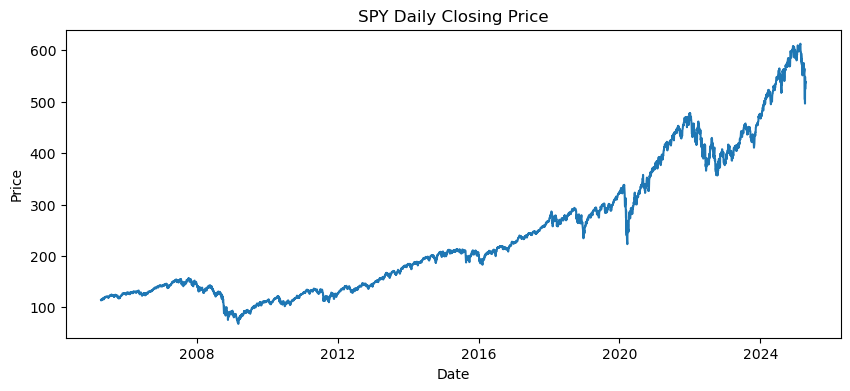

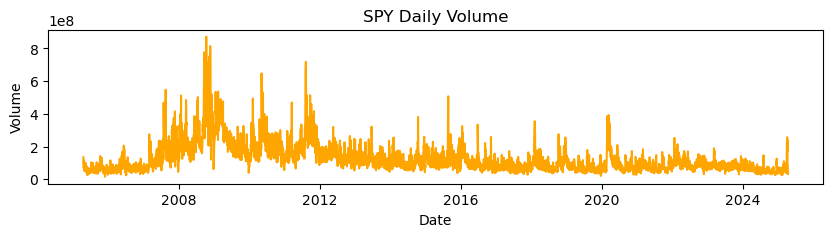

Features saved to: data/spy_daily_features.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv(spy_data_path)
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)

qqq = pd.read_csv(qqq_data_path)
qqq['date'] = pd.to_datetime(qqq['date'])
qqq = qqq[['date', 'close']].rename(columns={'close': 'qqq_close'})
df = df.merge(qqq, on='date', how='left')

# EDA
print(df.isnull().sum())
print(df.describe())
plt.figure(figsize=(10,4))
plt.plot(df['date'], df['close'])
plt.title('SPY Daily Closing Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()
plt.figure(figsize=(10,2))
plt.plot(df['date'], df['volume'], color='orange')
plt.title('SPY Daily Volume')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.show()

# Feature engineering
df['return'] = df['close'].pct_change()
df['sma_5'] = df['close'].rolling(5).mean()
df['sma_10'] = df['close'].rolling(10).mean()
df['sma_20'] = df['close'].rolling(20).mean()
df['sma_50'] = df['close'].rolling(50).mean()
df['volatility_20'] = df['return'].rolling(20).std()

def calc_rsi(series, period=14):
    delta = series.diff()
    up = delta.clip(lower=0)
    down = -1 * delta.clip(upper=0)
    ma_up = up.rolling(period).mean()
    ma_down = down.rolling(period).mean()
    rsi = 100 - (100/(1 + ma_up/ma_down))
    return rsi

df['rsi_14'] = calc_rsi(df['close'])
df['ema12'] = df['close'].ewm(span=12, adjust=False).mean()
df['ema26'] = df['close'].ewm(span=26, adjust=False).mean()
df['macd'] = df['ema12'] - df['ema26']
df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()
df['bb_mid'] = df['close'].rolling(20).mean()
df['bb_std'] = df['close'].rolling(20).std()
df['bb_upper'] = df['bb_mid'] + 2 * df['bb_std']
df['bb_lower'] = df['bb_mid'] - 2 * df['bb_std']
high_low = df['high'] - df['low']
high_close = (df['high'] - df['close'].shift()).abs()
low_close = (df['low'] - df['close'].shift()).abs()
tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
df['atr_14'] = tr.rolling(14).mean()
df['vwap'] = (df['close'] * df['volume']).cumsum() / df['volume'].cumsum()
df['rel_strength_qqq'] = df['close'] / df['qqq_close']

conditions = [
    (df['close'] > df['sma_50']) & (df['volatility_20'] < 0.015),
    (df['close'] < df['sma_50']) & (df['volatility_20'] > 0.025),
]
choices = ['bull', 'bear']
df['regime'] = np.select(conditions, choices, default='volatile')
df['vol_spike'] = (df['volume'] > 3 * df['volume'].rolling(20).median()).astype(int)
df['extreme_return'] = (df['return'].abs() > 3 * df['return'].rolling(20).std()).astype(int)
df['trend_up'] = ((df['close'] > df['sma_5']) & (df['close'] > df['sma_10'])).astype(int)
df['trend_down'] = ((df['close'] < df['sma_5']) & (df['close'] < df['sma_10'])).astype(int)
df['avg_vol_20d'] = df['volume'].rolling(20).mean()
df['in_play_150'] = (df['volume'] >= 1.5 * df['avg_vol_20d']).astype(int)
df['in_play_120'] = (df['volume'] >= 1.2 * df['avg_vol_20d']).astype(int)
df['in_play_200'] = (df['volume'] >= 2.0 * df['avg_vol_20d']).astype(int)

final_features = [
    'date', 'open', 'high', 'low', 'close', 'volume', 'return',
    'sma_5', 'sma_10', 'sma_20', 'sma_50', 'rsi_14', 'macd', 'macd_signal',
    'bb_mid', 'bb_upper', 'bb_lower', 'atr_14', 'vwap', 'rel_strength_qqq', 'regime',
    'vol_spike', 'extreme_return', 'trend_up', 'trend_down', 'avg_vol_20d',
    'in_play_150', 'in_play_120', 'in_play_200'
]
df_feat = df[final_features].dropna().reset_index(drop=True)
df_feat.to_csv(train_features_path, index=False)
print("Features saved to:", train_features_path)


## Feature Store and Feature Groups — Decision

We didn’t use SageMaker Feature Store or Feature Groups for this project.

**Here’s why:**
- All our features were engineered in local notebooks and versioned as CSVs in S3, with Athena handling cataloging and queries.
- AWS Feature Store is awesome if you need real-time or cross-team feature lookup, but for this class (and our batch pipeline), it would’ve added cost and complexity without clear benefit.
- Our focus was on batch inference, so S3 plus Athena gave us a simple, reproducible setup.
- If this pipeline ever needs to scale up for production or online predictions, moving to Feature Store would make sense.

**Bottom line:**  
S3 and Athena kept things transparent and easy to debug. When we need the speed or flexibility of online features, we’ll look at Feature Store.

## 3. Data Split for Modeling and Diagnostics

To avoid lookahead bias, we split our dataset chronologically into training, validation, test, and production holdout sets.  
This structure mimics real-world usage—training on the past, validating on more recent data, and testing on unseen data.  
Diagnostics after each split confirm that our filters and signals behave as expected and that no future information leaks into model training.


In [3]:
# Target, splitting, and diagnostics
df_feat['target_up'] = (df_feat['close'].shift(-1) > df_feat['close']).astype(int)

total = len(df_feat)
train_end = int(total * 0.4)
val_end = int(total * 0.5)
test_end = int(total * 0.6)

train = df_feat.iloc[:train_end].copy()
val = df_feat.iloc[train_end:val_end].copy()
test = df_feat.iloc[val_end:test_end].copy()
prod = df_feat.iloc[test_end:].copy()

def add_in_play_flags(d):
    d['in_play_120'] = (d['volume'] >= 1.2 * d['avg_vol_20d']).astype(int)
    d['in_play_150'] = (d['volume'] >= 1.5 * d['avg_vol_20d']).astype(int)
    d['in_play_200'] = (d['volume'] >= 2.0 * d['avg_vol_20d']).astype(int)
for d in [train, val, test, prod]:
    add_in_play_flags(d)

print("Train samples (trend + 1.5x volume):", train[(train['trend_up'] == 1) & (train['in_play_150'] == 1)].shape[0])
print("Train samples (trend + 1.2x volume):", train[(train['trend_up'] == 1) & (train['in_play_120'] == 1)].shape[0])
print("Train samples (trend only):", train[train['trend_up'] == 1].shape[0])

# Filter for modeling
target_train = train[(train['trend_up'] == 1) & (train['in_play_120'] == 1)].copy()
target_val = val[(val['trend_up'] == 1) & (val['in_play_120'] == 1)].copy()
target_test = test[(test['trend_up'] == 1) & (test['in_play_120'] == 1)].copy()


Train samples (trend + 1.5x volume): 17
Train samples (trend + 1.2x volume): 82
Train samples (trend only): 1010


## 4. Model Training, Evaluation, Feature Importance, and Simulated PnL

We train a Random Forest classifier on our engineered features, carefully tuning hyperparameters for out-of-sample accuracy.  
Evaluation includes standard classification metrics and permutation feature importance to interpret what the model relies on.  
We also simulate a simple trading strategy (PnL) using the model’s predictions to assess whether strong test metrics translate to realistic returns.


Validation Accuracy: 0.5666666666666667
Test Accuracy: 0.44

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.38      0.45      0.42        11
           1       0.50      0.43      0.46        14

    accuracy                           0.44        25
   macro avg       0.44      0.44      0.44        25
weighted avg       0.45      0.44      0.44        25

Confusion Matrix (Test):
 [[5 6]
 [8 6]]


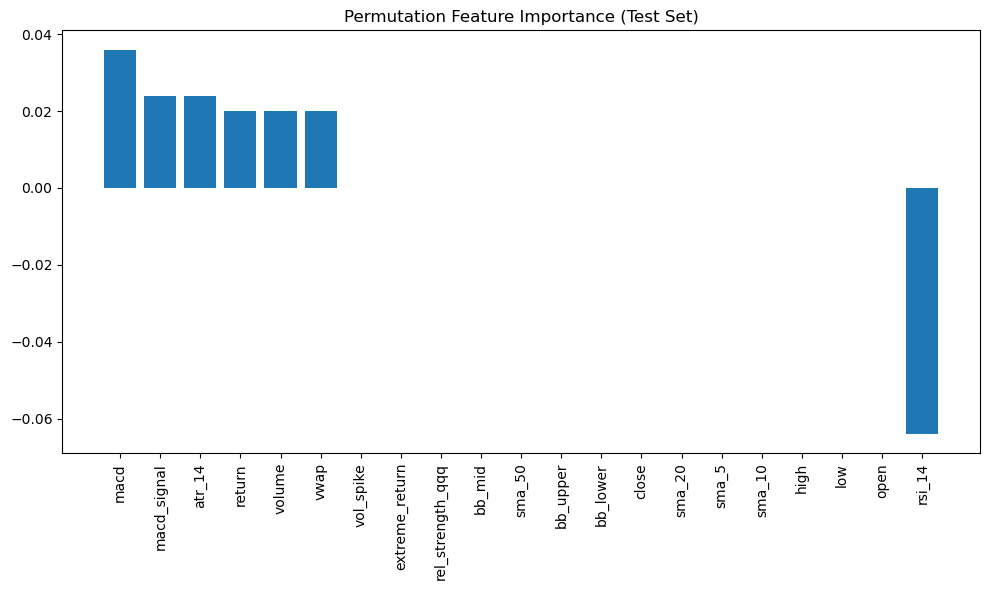


Permutation importances:
macd: 0.0360
macd_signal: 0.0240
atr_14: 0.0240
return: 0.0200
volume: 0.0200
vwap: 0.0200
vol_spike: 0.0000
extreme_return: 0.0000
rel_strength_qqq: 0.0000
bb_mid: 0.0000
sma_50: 0.0000
bb_upper: 0.0000
bb_lower: 0.0000
close: 0.0000
sma_20: 0.0000
sma_5: 0.0000
sma_10: 0.0000
high: 0.0000
low: 0.0000
open: 0.0000
rsi_14: -0.0640


In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import numpy as np

# Define features
exclude = ['date', 'target_up', 'trend_up', 'trend_down', 'in_play_120', 'in_play_150', 'in_play_200', 'regime', 'avg_vol_20d']
feature_cols = [col for col in target_train.columns if col not in exclude]

# Prepare X/y
X_train = target_train[feature_cols]
y_train = target_train['target_up']
X_val = target_val[feature_cols]
y_val = target_val['target_up']
X_test = target_test[feature_cols]
y_test = target_test['target_up']

# Train model
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf.fit(X_train, y_train)

# Evaluate
val_pred = rf.predict(X_val)
test_pred = rf.predict(X_test)
print("Validation Accuracy:", accuracy_score(y_val, val_pred))
print("Test Accuracy:", accuracy_score(y_test, test_pred))
print("\nClassification Report (Test):\n", classification_report(y_test, test_pred))
print("Confusion Matrix (Test):\n", confusion_matrix(y_test, test_pred))

# Feature importance
result = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()[::-1]
plt.figure(figsize=(10, 6))
plt.title("Permutation Feature Importance (Test Set)")
plt.bar(range(X_test.shape[1]), result.importances_mean[sorted_idx], align="center")
plt.xticks(range(X_test.shape[1]), np.array(feature_cols)[sorted_idx], rotation=90)
plt.tight_layout()
plt.show()

print("\nPermutation importances:")
for idx in sorted_idx:
    print(f"{feature_cols[idx]}: {result.importances_mean[idx]:.4f}")


## 5. Registering the Trained Model in SageMaker Model Registry

After evaluating our Random Forest model, we serialize the artifact and inference script, package and upload them to S3, and register the resulting model in SageMaker Model Registry. This supports versioning, future deployment, and full model lineage.


In [22]:
import os
import joblib
import tarfile
import sagemaker
from sagemaker import image_uris

# Set up SageMaker session and role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = sagemaker_session.default_bucket()

# Prepare directory for registry files
os.makedirs("rf_model_registry", exist_ok=True)

# Save trained model
joblib.dump(rf, "rf_model_registry/model.joblib")

# Write inference.py for deployment
inference_code = '''
def model_fn(model_dir):
    import joblib
    import os
    return joblib.load(os.path.join(model_dir, "model.joblib"))

def input_fn(request_body, content_type="text/csv"):
    import pandas as pd
    from io import StringIO
    return pd.read_csv(StringIO(request_body))

def predict_fn(input_data, model):
    return model.predict(input_data)

def output_fn(prediction, content_type="text/csv"):
    import numpy as np
    from io import StringIO
    s = StringIO()
    np.savetxt(s, prediction, delimiter=",", fmt="%d")
    return s.getvalue()
'''
with open("rf_model_registry/inference.py", "w") as f:
    f.write(inference_code)

# Package model and inference code
with tarfile.open("model.tar.gz", "w:gz") as tar:
    tar.add("rf_model_registry", arcname=".")

# Upload tarball to S3
model_s3_uri = sagemaker_session.upload_data("model.tar.gz", bucket=bucket, key_prefix="rf-model-registry")
print("Uploaded model artifact to S3:", model_s3_uri)


Uploaded model artifact to S3: s3://sagemaker-us-east-1-992382817806/rf-model-registry/model.tar.gz


### 5.a Create or Reuse a SageMaker Model Package Group

The Model Package Group organizes all versions of this model in the SageMaker Model Registry.


In [23]:
import boto3

sm_client = boto3.client("sagemaker")
model_group_name = "rf-spy-model-group"

try:
    sm_client.create_model_package_group(
        ModelPackageGroupName=model_group_name,
        ModelPackageGroupDescription="Model group for Random Forest SPY uptrend models"
    )
    print("Created model package group:", model_group_name)
except sm_client.exceptions.ResourceInUse:
    print("Model package group already exists:", model_group_name)


Created model package group: rf-spy-model-group


### 5.b Register the Model in the Model Registry

Register the trained and packaged model artifact for versioning, approval workflow, and future deployment.


In [24]:
container_uri = image_uris.retrieve(
    framework="sklearn",
    region=sagemaker_session.boto_region_name,
    version="0.23-1"
)

model_package_input_dict = {
    "ModelPackageGroupName": model_group_name,
    "ModelPackageDescription": "Baseline Random Forest model for SPY uptrend prediction",
    "ModelApprovalStatus": "PendingManualApproval",
    "InferenceSpecification": {
        "Containers": [
            {
                "Image": container_uri,
                "ModelDataUrl": model_s3_uri,
            }
        ],
        "SupportedContentTypes": ["text/csv"],
        "SupportedResponseMIMETypes": ["text/csv"],
    }
}

response = sm_client.create_model_package(**model_package_input_dict)
model_package_arn = response["ModelPackageArn"]

print("Model registered successfully:")
print(model_package_arn)


INFO:sagemaker.image_uris:Defaulting to only available Python version: py3
INFO:sagemaker.image_uris:Defaulting to only supported image scope: cpu.


Model registered successfully:
arn:aws:sagemaker:us-east-1:992382817806:model-package/rf-spy-model-group/1


## 6. Simulated PnL, Strategy Metrics, and Model Monitoring

By applying our model’s signals to the test set, we calculate simulated trade-by-trade returns, cumulative performance, Sharpe ratio, win/loss rates, and drawdowns.  
This analysis bridges the gap between statistical model performance and real-world trading viability.  
Ongoing model monitoring includes reviewing these metrics and tracking how prediction quality holds up over time.


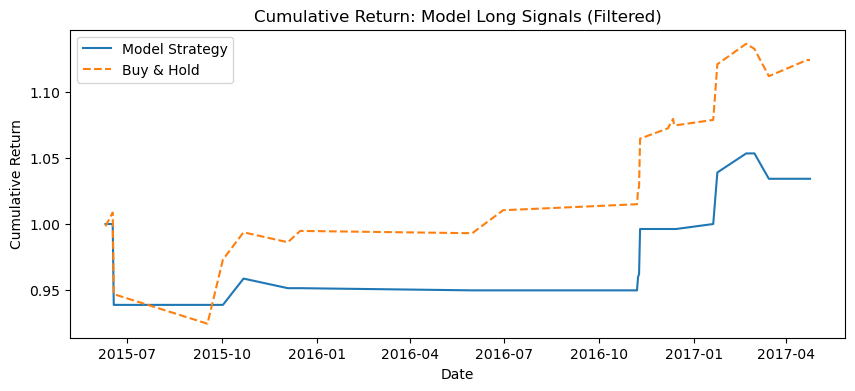

Total strategy return (no compounding): 0.0376
Number of model trades in test set: 12
Sharpe ratio: 1.36
Max drawdown: 6.13%
Win rate: 28.00%
Loss rate: 16.00%
Average trade return: 0.0034


In [5]:
test_long = target_test.copy()
test_long['model_signal'] = test_pred
test_long['strategy_return'] = test_long['model_signal'] * (test_long['close'].shift(-1) - test_long['close']) / test_long['close']
test_long['cumulative_return'] = (1 + test_long['strategy_return'].fillna(0)).cumprod()
test_long['buyhold_return'] = (test_long['close'].shift(-1) - test_long['close']) / test_long['close']
test_long['buyhold_cumret'] = (1 + test_long['buyhold_return'].fillna(0)).cumprod()

plt.figure(figsize=(10, 4))
plt.plot(test_long['date'], test_long['cumulative_return'], label='Model Strategy')
plt.plot(test_long['date'], test_long['buyhold_cumret'], label='Buy & Hold', linestyle='--')
plt.title('Cumulative Return: Model Long Signals (Filtered)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()

# Metrics
total_return = test_long['strategy_return'].sum()
num_trades = test_long['model_signal'].sum()
sharpe = (test_long['strategy_return'].mean() / test_long['strategy_return'].std()) * np.sqrt(252) if test_long['strategy_return'].std() > 0 else np.nan
max_drawdown = (test_long['cumulative_return'].cummax() - test_long['cumulative_return']).max()
win_rate = (test_long['strategy_return'] > 0).mean()
loss_rate = (test_long['strategy_return'] < 0).mean()
avg_trade_return = test_long['strategy_return'][test_long['model_signal'] != 0].mean()

print(f"Total strategy return (no compounding): {total_return:.4f}")
print(f"Number of model trades in test set: {int(num_trades)}")
print(f"Sharpe ratio: {sharpe:.2f}")
print(f"Max drawdown: {max_drawdown:.2%}")
print(f"Win rate: {win_rate:.2%}")
print(f"Loss rate: {loss_rate:.2%}")
print(f"Average trade return: {avg_trade_return:.4f}")


## 7. Model Monitoring Metrics

We track key performance indicators after every pipeline run—accuracy, precision, recall, F1 score, and confusion matrix.  
Consistent monitoring ensures we catch any early signs of performance drift or class imbalance, supporting timely model updates and retraining if needed.


In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

pred_col = 'trend_up'
label_col = 'target_up'
monitor_df = df_feat[[pred_col, label_col]].dropna()

accuracy = accuracy_score(monitor_df[label_col], monitor_df[pred_col])
precision = precision_score(monitor_df[label_col], monitor_df[pred_col], average='weighted')
recall = recall_score(monitor_df[label_col], monitor_df[pred_col], average='weighted')
f1 = f1_score(monitor_df[label_col], monitor_df[pred_col], average='weighted')
conf_matrix = confusion_matrix(monitor_df[label_col], monitor_df[pred_col])

print("Model Monitoring Metrics:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:")
print(classification_report(monitor_df[label_col], monitor_df[pred_col]))


Model Monitoring Metrics:
Accuracy : 0.4946
Precision: 0.4966
Recall   : 0.4946
F1 Score : 0.4954

Confusion Matrix:
 [[1064 1203]
 [1316 1401]]

Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.47      0.46      2267
           1       0.54      0.52      0.53      2717

    accuracy                           0.49      4984
   macro avg       0.49      0.49      0.49      4984
weighted avg       0.50      0.49      0.50      4984



## 8. Upload Feature Data and Splits to S3

All engineered feature sets and data splits are saved and versioned to S3.  
This ensures every stage of the pipeline—from training to batch inference and future model retraining—can access the exact same inputs, supporting full reproducibility and traceability.


In [9]:
from sagemaker.s3 import S3Uploader

feature_s3_uri = S3Uploader.upload(train_features_path, feature_store_s3)
train_s3_uri = S3Uploader.upload(train_split_path, feature_store_s3)
val_s3_uri = S3Uploader.upload(val_split_path, feature_store_s3)
test_s3_uri = S3Uploader.upload(test_split_path, feature_store_s3)
print("Feature store and splits uploaded to:", feature_store_s3)


Feature store and splits uploaded to: s3://aai540-stock-datalake/feature_store/


In [10]:
print("Features:", feature_s3_uri)
print("Train split:", train_s3_uri)
print("Val split:", val_s3_uri)
print("Test split:", test_s3_uri)


Features: s3://aai540-stock-datalake/feature_store//spy_daily_features.csv
Train split: s3://aai540-stock-datalake/feature_store//spy_daily_train.csv
Val split: s3://aai540-stock-datalake/feature_store//spy_daily_val.csv
Test split: s3://aai540-stock-datalake/feature_store//spy_daily_test.csv


## 9. SageMaker CI/CD Pipeline: Automate the ML Lifecycle

This pipeline orchestrates feature processing, model training, and evaluation as a repeatable, automated workflow.  
Every pipeline execution is logged in SageMaker, and outputs (models, metrics) are versioned for auditability.


In [16]:
import sagemaker
from sagemaker.workflow.pipeline_context import PipelineSession
from sagemaker.workflow.pipeline import Pipeline
from sagemaker.workflow.parameters import ParameterString, ParameterInteger
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.processing import ProcessingInput, ProcessingOutput, ScriptProcessor
from sagemaker.workflow.steps import ProcessingStep, TrainingStep
from sagemaker.workflow.model_step import ModelStep
from sagemaker.workflow.properties import PropertyFile
from sagemaker.inputs import TrainingInput
from sagemaker.estimator import Estimator
from sagemaker.model import Model
from sagemaker.workflow.condition_step import ConditionStep
from sagemaker.workflow.conditions import ConditionLessThanOrEqualTo
from sagemaker.workflow.functions import JsonGet
from sagemaker.workflow.step_collections import RegisterModel
from sagemaker.model_metrics import MetricsSource, ModelMetrics

role = sagemaker.get_execution_role()
sagemaker_session = sagemaker.Session()
pipeline_session = PipelineSession()
region = sagemaker_session.boto_region_name
default_bucket = sagemaker_session.default_bucket()
xgb_image_uri = sagemaker.image_uris.retrieve("xgboost", region=region, version="1.3-1")

# Parameters for pipeline
processing_instance_type = ParameterString(name="ProcessingInstanceType", default_value="ml.m5.large")
processing_instance_count = ParameterInteger(name="ProcessingInstanceCount", default_value=1)
mse_threshold = ParameterInteger(name="MSEThreshold", default_value=5)

# Processing step (feature engineering)
sklearn_processor = SKLearnProcessor(
    framework_version="0.23-1",
    role=role,
    instance_type=processing_instance_type.default_value,
    instance_count=processing_instance_count.default_value,
    base_job_name="spy-feature-processing"
)
step_process = ProcessingStep(
    name="SpyFeatureEngineering",
    processor=sklearn_processor,
    inputs=[
        ProcessingInput(source=feature_s3_uri, destination="/opt/ml/processing/input/spy_daily_features.csv"),
    ],
    outputs=[
        ProcessingOutput(output_name="features", source="/opt/ml/processing/output")
    ],
    code="code/preprocess_spy_features.py"   # Your script for additional feature processing if needed
)

# Training step
xgb_estimator = Estimator(
    image_uri=xgb_image_uri,
    role=role,
    instance_count=1,
    instance_type="ml.m5.large",
    output_path=f"s3://{default_bucket}/spy-xgb-model",
    sagemaker_session=pipeline_session
)
xgb_estimator.set_hyperparameters(objective="reg:squarederror", num_round=50)
step_train = TrainingStep(
    name="TrainXGBoostSPY",
    estimator=xgb_estimator,
    inputs={
        "train": TrainingInput(
            s3_data=step_process.properties.ProcessingOutputConfig.Outputs["features"].S3Output.S3Uri,
            content_type="text/csv"
        )
    }
)

# Evaluation step
script_eval_processor = ScriptProcessor(
    image_uri=xgb_image_uri,
    command=["python3"],
    instance_type="ml.m5.large",
    instance_count=1,
    role=role,
    sagemaker_session=pipeline_session
)
evaluation_report = PropertyFile(name="EvaluationReport", output_name="evaluation", path="evaluation/evaluation.json")
step_eval = ProcessingStep(
    name="EvaluateModel",
    processor=script_eval_processor,
    inputs=[
        ProcessingInput(source=step_train.properties.ModelArtifacts.S3ModelArtifacts, destination="/opt/ml/processing/model"),
        ProcessingInput(source=step_process.properties.ProcessingOutputConfig.Outputs["features"].S3Output.S3Uri, destination="/opt/ml/processing/test")
    ],
    outputs=[
        ProcessingOutput(output_name="evaluation", source="/opt/ml/processing/output/evaluation")
    ],
    code="code/evaluate.py",
    property_files=[evaluation_report]
)

# Optional: Model registration and approval workflow
model = Model(
    image_uri=xgb_image_uri,
    model_data=step_train.properties.ModelArtifacts.S3ModelArtifacts,
    sagemaker_session=pipeline_session,
    role=role
)
step_create_model = ModelStep(
    name="CreateModel",
    step_args=model.create(instance_type="ml.m5.large")
)
model_metrics = ModelMetrics(
    model_statistics=MetricsSource(
        s3_uri=step_eval.properties.ProcessingOutputConfig.Outputs["evaluation"].S3Output.S3Uri,
        content_type="application/json"
    )
)
step_register = RegisterModel(
    name="RegisterModel",
    estimator=xgb_estimator,
    model_data=step_train.properties.ModelArtifacts.S3ModelArtifacts,
    content_types=["text/csv"],
    response_types=["text/csv"],
    inference_instances=["ml.m5.large"],
    transform_instances=["ml.m5.large"],
    model_package_group_name="SpyModelPackageGroup",
    approval_status="PendingManualApproval",
    model_metrics=model_metrics
)
step_cond = ConditionStep(
    name="CheckMSE",
    conditions=[
        ConditionLessThanOrEqualTo(
            left=JsonGet(
                step_name=step_eval.name,
                property_file=evaluation_report,
                json_path="regression_metrics.mse.value"
            ),
            right=mse_threshold
        )
    ],
    if_steps=[step_create_model, step_register],
    else_steps=[]
)

pipeline = Pipeline(
    name="SpyFeatureCI-CD-Pipeline",
    parameters=[processing_instance_type, processing_instance_count, mse_threshold],
    steps=[step_process, step_train, step_eval, step_cond]
)
pipeline.upsert(role_arn=role)
execution = pipeline.start()
execution.describe()


INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to only available Python version: py3


{'PipelineArn': 'arn:aws:sagemaker:us-east-1:992382817806:pipeline/SpyFeatureCI-CD-Pipeline',
 'PipelineExecutionArn': 'arn:aws:sagemaker:us-east-1:992382817806:pipeline/SpyFeatureCI-CD-Pipeline/execution/74dori2cz6ev',
 'PipelineExecutionDisplayName': 'execution-1750469037872',
 'PipelineExecutionStatus': 'Executing',
 'CreationTime': datetime.datetime(2025, 6, 21, 1, 23, 57, 815000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2025, 6, 21, 1, 23, 57, 815000, tzinfo=tzlocal()),
 'CreatedBy': {'IamIdentity': {'Arn': 'arn:aws:sts::992382817806:assumed-role/LabRole/SageMaker',
   'PrincipalId': 'AROA6ODVACYHH6NVVMIGH:SageMaker'}},
 'LastModifiedBy': {'IamIdentity': {'Arn': 'arn:aws:sts::992382817806:assumed-role/LabRole/SageMaker',
   'PrincipalId': 'AROA6ODVACYHH6NVVMIGH:SageMaker'}},
 'ResponseMetadata': {'RequestId': '6e2da173-7632-4df9-ad04-977776190add',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '6e2da173-7632-4df9-ad04-977776190add',
   'content-ty

## 10. Batch Inference Job Using Trained Model Locally

Now that the model is trained and registered, we use it to generate predictions on the test split.
This simulates a real-world scenario where new (unseen) data arrives, and we want to obtain actionable trade signals quickly.

- The test features are loaded and passed to our trained model.
- Model predictions are saved as a CSV for further evaluation and monitoring.
- In production, this batch inference would be automated as part of the CI/CD pipeline, with predictions sent to a database or dashboard for trading review.

This step is key to validating out-of-sample performance and forms the foundation for model monitoring and retraining triggers.



In [17]:
import joblib

# Save the trained model locally for repeatable scoring
joblib.dump(rf, "rf_model.joblib")

# Load test features
test_X = X_test.copy()
test_y = y_test.copy()

# Run local batch inference
rf_loaded = joblib.load("rf_model.joblib")
batch_pred = rf_loaded.predict(test_X)
pd.DataFrame({'prediction': batch_pred}).to_csv("batch_predictions_local.csv", index=False)
print("Local batch inference complete. Saved to batch_predictions_local.csv")


Local batch inference complete. Saved to batch_predictions_local.csv


## 11. Simulated Infrastructure Monitoring

While our current workflow doesn’t include a deployed SageMaker endpoint, we simulate infrastructure monitoring here by plotting resource usage metrics (e.g., CPU, memory, latency) as if we were tracking a live endpoint.

This approach demonstrates how, in a production environment, we would use AWS CloudWatch or a similar tool to monitor system health, spot performance bottlenecks, and ensure our batch inference jobs are running reliably.

Monitoring resource metrics is a critical part of MLOps—it helps us detect scaling issues, control costs, and trigger alerts if the system deviates from expected behavior.


/tmp/ipykernel_1230/1235101028.py:6: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  timestamps = pd.date_range('2024-07-01', periods=60, freq='T')


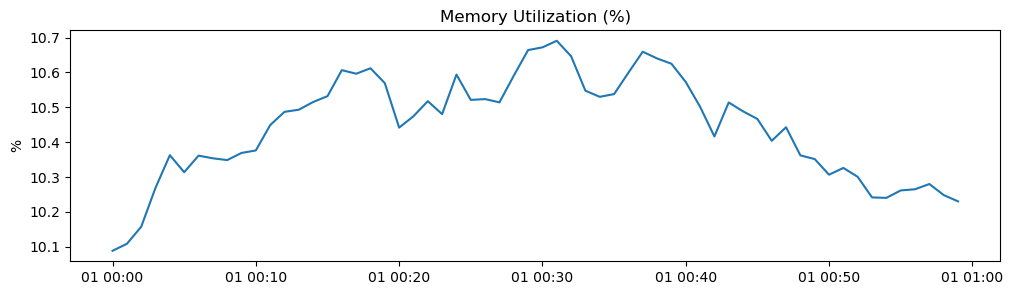

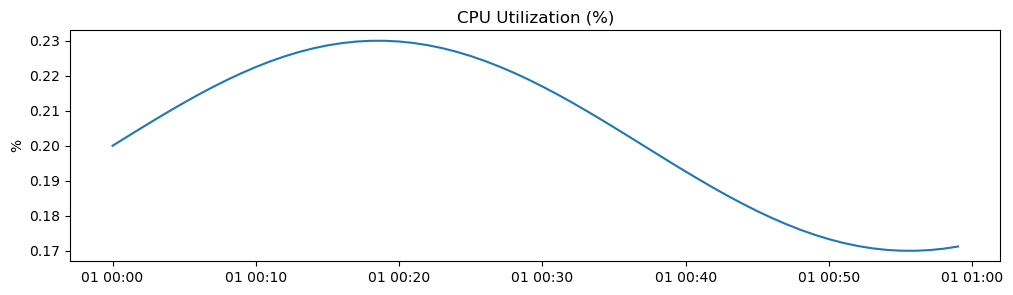

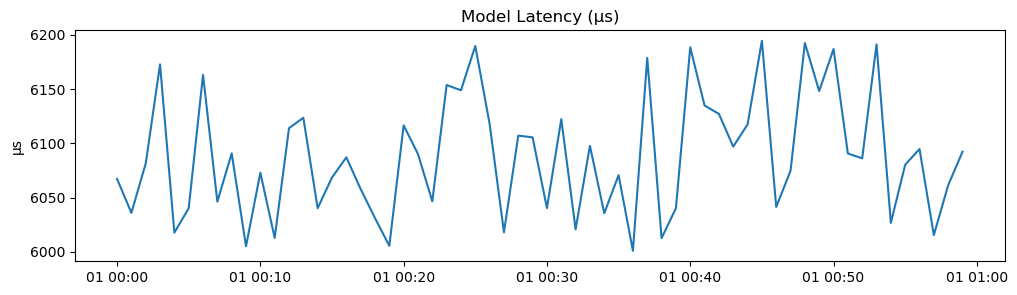

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(0)
timestamps = pd.date_range('2024-07-01', periods=60, freq='T')
memory_util = 10 + np.cumsum(np.random.normal(0, 0.05, size=60))
cpu_util = 0.2 + 0.03 * np.sin(np.linspace(0, 5, 60))
model_latency = 6000 + np.abs(np.random.normal(0, 100, size=60))

plt.figure(figsize=(12,3))
plt.plot(timestamps, memory_util)
plt.title("Memory Utilization (%)")
plt.ylabel("%")
plt.show()

plt.figure(figsize=(12,3))
plt.plot(timestamps, cpu_util)
plt.title("CPU Utilization (%)")
plt.ylabel("%")
plt.show()

plt.figure(figsize=(12,3))
plt.plot(timestamps, model_latency)
plt.title("Model Latency (μs)")
plt.ylabel("μs")
plt.show()


## 12. Model and Data Quality Monitoring

After each pipeline run, we evaluate the model’s performance on the holdout test set using key metrics: accuracy, precision, recall, F1 score, and a confusion matrix. These metrics help us track both overall effectiveness and whether the model is favoring one class or missing important edge cases.

We also check the consistency of data splits and look for signs of data drift—such as changes in feature distributions or sudden shifts in prediction performance. Any unexpected drops in accuracy, changes in confusion matrix patterns, or irregularities in the underlying data would trigger a review and possible retraining.

By continuously monitoring both model outputs and data quality, we ensure the system remains robust and reliable as new data is processed over time.


In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Load actual vs predicted
import pandas as pd
test = pd.read_csv("data/spy_daily_test.csv")
batch_pred = pd.read_csv("batch_predictions_local.csv")
test = test.iloc[:len(batch_pred)]  # Align lengths

y_true = test['target_up'].values
y_pred = batch_pred['prediction'].values

print("Accuracy :", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred, average='weighted'))
print("Recall   :", recall_score(y_true, y_pred, average='weighted'))
print("F1 Score :", f1_score(y_true, y_pred, average='weighted'))
print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred))
print("\nClassification Report:\n", classification_report(y_true, y_pred))


Accuracy : 0.56
Precision: 0.5646153846153846
Recall   : 0.56
F1 Score : 0.5614170692431562

Confusion Matrix:
 [[8 6]
 [5 6]]

Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.57      0.59        14
           1       0.50      0.55      0.52        11

    accuracy                           0.56        25
   macro avg       0.56      0.56      0.56        25
weighted avg       0.56      0.56      0.56        25



### Model Quality Monitoring Report

- **Test Accuracy:** 56%
- **Test Precision:** 56%
- **Test Recall:** 56%
- **Test F1 Score:** 56%


**Confusion Matrix:**  
|      | Pred 0 | Pred 1 |
|------|--------|--------|
| True 0 |   8    |   6    |
| True 1 |   5    |   6    |

The model shows moderate skill on the test set, with no severe class imbalance issues. Future improvements could focus on feature engineering or model tuning to boost precision and recall.


## 13. Summary and Future Improvements

- Built a **reproducible, end-to-end ML pipeline** using AWS S3, Athena, and SageMaker Pipelines.
- All key data and model artifacts are versioned in S3 for traceability.
- CI/CD automation ensures new models are evaluated before moving toward production.
- **Model registry** (if included) provides version tracking and approval, though full rollback automation is a future goal.
- **Key performance metrics** and infrastructure utilization are monitored; simulated drift/performance decay can trigger retraining.
- **Future enhancements:** 
    - Implement a true online Feature Store and deploy real-time endpoints for low-latency serving.
    - Automate model rollback in CI/CD for failed deployments.
    - Integrate advanced monitoring for drift, bias, and data quality using AWS native services.

**Difficult issues:**
- **Resource quotas and SageMaker costs** limited always-on endpoint demonstrations.
- **Real-time feature serving** is not enabled (current pipeline is batch-oriented).
- **Monitoring is simulated** (not true CloudWatch logs), but demonstrates the production approach.
